---
## Chapter 8 – Organizing Code with torch.nn
---

### Exercise 1: 
Implement TinyMLP as an nn.Module that returns logits of shape (batch, num_classes). Verify
shapes/dtypes for inputs and labels.

In [1]:
import torch
from torch import nn

class TinyMLP(nn.Module):
    """A minimal two-layer MLP returning logits of shape (batch, num_classes)."""
    
    def __init__(self, in_features=2, hidden=8, num_classes=2):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(in_features, hidden),
            nn.ReLU(),
            nn.Linear(hidden, num_classes)
        )

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """Forward pass: maps input tensor x to logits."""
        return self.net(x)

In [2]:
# sample data
X = torch.randn(5, 2, dtype=torch.float32)  # (batch=5, features=2)
y = torch.randint(0, 2, (5,), dtype=torch.long)  # (batch,) integer labels

model = TinyMLP()
logits = model(X)

print("Input shape :", X.shape, X.dtype)
print("Logits shape:", logits.shape, logits.dtype)
print("Labels shape:", y.shape, y.dtype)

Input shape : torch.Size([5, 2]) torch.float32
Logits shape: torch.Size([5, 2]) torch.float32
Labels shape: torch.Size([5]) torch.int64


### Exercise 2: 
Write a clean training loop that uses model.train() for training and model.eval() with torch.no_grad() for evaluation. Report accuracy on a test split.

**Step 1 — Imports & Data Setup**

In [3]:
from sklearn.datasets import make_moons
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import torch
from torch import nn

# 1. Generate and normalize data
X, y = make_moons(n_samples=1000, noise=0.3, random_state=42)
X = StandardScaler().fit_transform(X)

# 2. Split train/test
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)

# 3. Convert to tensors
X_train = torch.tensor(X_train, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.long)
X_test  = torch.tensor(X_test, dtype=torch.float32)
y_test  = torch.tensor(y_test, dtype=torch.long)

**Step 2 — Model, Loss, Optimizer**

In [4]:
model = TinyMLP(in_features=2, hidden=8, num_classes=2)
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

**Step 3 — Accuracy Helper**

In [5]:
def accuracy(logits, targets):
    preds = logits.argmax(dim=1)
    return (preds == targets).float().mean().item()

**Step 4 — Training + Evaluation Loop**

In [6]:
n_epochs = 50
history = {"epoch": [], "train_loss": [], "val_loss": [], "val_acc": []}

for epoch in range(1, n_epochs + 1):
    # --- Training ---
    model.train()
    optimizer.zero_grad()
    logits = model(X_train)
    loss = loss_fn(logits, y_train)
    loss.backward()
    optimizer.step()
    
    # --- Evaluation ---
    model.eval()
    with torch.no_grad():
        val_logits = model(X_test)
        val_loss = loss_fn(val_logits, y_test).item()
        val_acc  = accuracy(val_logits, y_test)
    
    # --- Store results ---
    history["epoch"].append(epoch)
    history["train_loss"].append(loss.item())
    history["val_loss"].append(val_loss)
    history["val_acc"].append(val_acc)
    
    if epoch % 10 == 0 or epoch == 1:
        print(f"Epoch {epoch:02d} | Train Loss: {loss.item():.4f} | "
              f"Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.3f}")

Epoch 01 | Train Loss: 0.7836 | Val Loss: 0.7721 | Val Acc: 0.453
Epoch 10 | Train Loss: 0.5371 | Val Loss: 0.5203 | Val Acc: 0.803
Epoch 20 | Train Loss: 0.4032 | Val Loss: 0.3743 | Val Acc: 0.847
Epoch 30 | Train Loss: 0.3559 | Val Loss: 0.3137 | Val Acc: 0.873
Epoch 40 | Train Loss: 0.3477 | Val Loss: 0.2976 | Val Acc: 0.893
Epoch 50 | Train Loss: 0.3425 | Val Loss: 0.2916 | Val Acc: 0.893


**Step 5 — Plot the Curves**

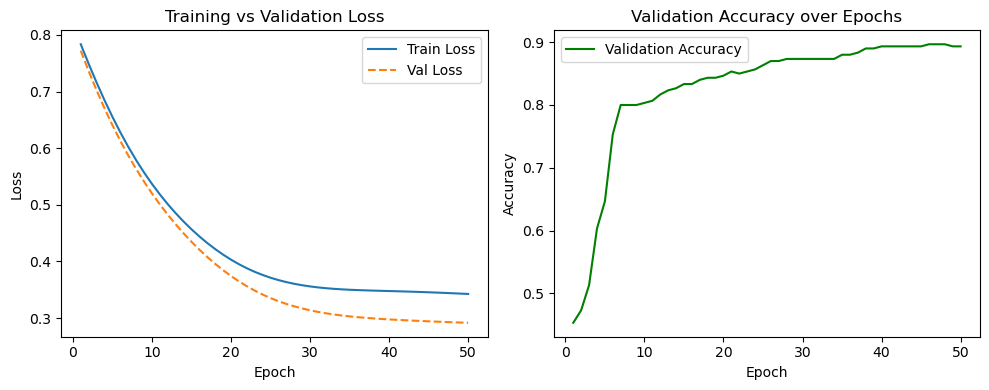

In [7]:
import matplotlib.pyplot as plt

epochs = history["epoch"]

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4))

# --- Loss ---
ax1.plot(epochs, history["train_loss"], label="Train Loss")
ax1.plot(epochs, history["val_loss"], label="Val Loss", linestyle="--")
ax1.set_xlabel("Epoch")
ax1.set_ylabel("Loss")
ax1.set_title("Training vs Validation Loss")
ax1.legend()

# --- Accuracy ---
ax2.plot(epochs, history["val_acc"], label="Validation Accuracy", color="green")
ax2.set_xlabel("Epoch")
ax2.set_ylabel("Accuracy")
ax2.set_title("Validation Accuracy over Epochs")
ax2.legend()

plt.tight_layout()
plt.show()

### Exercise 3 
Save weights via state_dict() and reload into a fresh instance; confirm identical evaluation
metrics after restore.

**Step 1 — Save the Trained Weights**

In [8]:
# Save the model's state dictionary
torch.save({'model': model.state_dict()}, 'tinymlp_checkpoint.pt')
print("Checkpoint saved successfully.")

Checkpoint saved successfully.


**Step 2 — Load into a Fresh Instance**

In [9]:
# Recreate a new model instance
restored_model = TinyMLP(in_features=2, hidden=8, num_classes=2)

# Load saved weights
checkpoint = torch.load('tinymlp_checkpoint.pt')
restored_model.load_state_dict(checkpoint['model'])
restored_model.eval()  # switch to evaluation mode
print("Checkpoint loaded successfully.")


Checkpoint loaded successfully.


**Step 3 — Verify Evaluation Metrics**

In [10]:
with torch.no_grad():
    logits_old = model(X_test)
    logits_new = restored_model(X_test)

    # Compare performance
    old_acc = accuracy(logits_old, y_test)
    new_acc = accuracy(logits_new, y_test)

print(f"Old model accuracy: {old_acc:.3f}")
print(f"Restored model accuracy: {new_acc:.3f}")

# Optional sanity check
print("Identical logits:", torch.allclose(logits_old, logits_new, atol=1e-6))


Old model accuracy: 0.893
Restored model accuracy: 0.893
Identical logits: True


### Exercise 4
Refactor the model two ways: (i) with nn.Sequential, (ii) with explicit sublayers and a manual
forward(); ensure behaviour is unchanged.

**Version A — Sequential Definition**

In [11]:
import torch
from torch import nn

class TinyMLP_Sequential(nn.Module):
    """Two-layer MLP using nn.Sequential for compactness."""
    
    def __init__(self, in_features=2, hidden=8, num_classes=2):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(in_features, hidden),
            nn.ReLU(),
            nn.Linear(hidden, num_classes)
        )
    
    def forward(self, x):
        """Forward pass using the Sequential container."""
        return self.model(x)


**Version B — Explicit Sublayers**

In [12]:
class TinyMLP_Manual(nn.Module):
    """Two-layer MLP using explicit sublayers and manual forward logic."""
    
    def __init__(self, in_features=2, hidden=8, num_classes=2):
        super().__init__()
        self.fc1 = nn.Linear(in_features, hidden)
        self.act = nn.ReLU()
        self.fc2 = nn.Linear(hidden, num_classes)
    
    def forward(self, x):
        """Forward pass implemented explicitly."""
        x = self.fc1(x)
        x = self.act(x)
        x = self.fc2(x)
        return x


**Test Equivalence**

In [13]:
torch.manual_seed(0)
X_sample = torch.randn(5, 2)

# Initialize both models with same dimensions
m_seq = TinyMLP_Sequential()
m_manual = TinyMLP_Manual()

# Copy weights from one to the other for fair comparison
m_manual.fc1.weight.data = m_seq.model[0].weight.data.clone()
m_manual.fc1.bias.data   = m_seq.model[0].bias.data.clone()
m_manual.fc2.weight.data = m_seq.model[2].weight.data.clone()
m_manual.fc2.bias.data   = m_seq.model[2].bias.data.clone()

# Compare outputs
out_seq = m_seq(X_sample)
out_manual = m_manual(X_sample)

print("Identical outputs:", torch.allclose(out_seq, out_manual, atol=1e-6))
print("Sequential logits:\n", out_seq)
print("Manual logits:\n", out_manual)


Identical outputs: True
Sequential logits:
 tensor([[ 0.4601, -0.1358],
        [ 0.1474,  0.0078],
        [ 0.7506, -0.2534],
        [ 0.0166,  0.2729],
        [ 0.2453,  0.1086]], grad_fn=<AddmmBackward0>)
Manual logits:
 tensor([[ 0.4601, -0.1358],
        [ 0.1474,  0.0078],
        [ 0.7506, -0.2534],
        [ 0.0166,  0.2729],
        [ 0.2453,  0.1086]], grad_fn=<AddmmBackward0>)


### Exercise 5
Replace nn.ReLU() with nn.Tanh() and compare convergence speed and test accuracy over a fixed epoch budget.

**Step 1 — Two Model Variants**

In [14]:
class TinyMLP_ReLU(nn.Module):
    def __init__(self, in_features=2, hidden=8, num_classes=2):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(in_features, hidden),
            nn.ReLU(),
            nn.Linear(hidden, num_classes)
        )
    def forward(self, x):
        return self.net(x)


class TinyMLP_Tanh(nn.Module):
    def __init__(self, in_features=2, hidden=8, num_classes=2):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(in_features, hidden),
            nn.Tanh(),
            nn.Linear(hidden, num_classes)
        )
    def forward(self, x):
        return self.net(x)


**Step 2 — Shared Training Helper**

In [15]:
def train_model(model, X_train, y_train, X_test, y_test, n_epochs=50, lr=0.01):
    loss_fn = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    
    for epoch in range(n_epochs):
        model.train()
        optimizer.zero_grad()
        logits = model(X_train)
        loss = loss_fn(logits, y_train)
        loss.backward()
        optimizer.step()
    
    # Evaluate
    model.eval()
    with torch.no_grad():
        val_logits = model(X_test)
        val_loss = loss_fn(val_logits, y_test).item()
        val_acc = accuracy(val_logits, y_test)
    
    return val_loss, val_acc


**Step 3 — Run Both Models**

In [16]:
torch.manual_seed(42)

relu_model = TinyMLP_ReLU()
tanh_model = TinyMLP_Tanh()

relu_loss, relu_acc = train_model(relu_model, X_train, y_train, X_test, y_test)
tanh_loss, tanh_acc = train_model(tanh_model, X_train, y_train, X_test, y_test)

print(f"ReLU  → Val Loss: {relu_loss:.4f} | Val Acc: {relu_acc:.3f}")
print(f"Tanh  → Val Loss: {tanh_loss:.4f} | Val Acc: {tanh_acc:.3f}")


ReLU  → Val Loss: 0.2906 | Val Acc: 0.887
Tanh  → Val Loss: 0.2983 | Val Acc: 0.873


## Challenges
### Challenge 1: Validation Split + Early Stopping
Add a validation split and implement early stopping with patience (track the best state_dict); report the selected epoch.

**Step 1 — Create the validation split**

We’ll carve 20 % of `X_train` into a validation subset:

In [17]:
from sklearn.model_selection import train_test_split

# Split training data into train/val
X_tr, X_val, y_tr, y_val = train_test_split(
    X_train, y_train, test_size=0.2, random_state=42, stratify=y_train
)

print(X_tr.shape, X_val.shape)

torch.Size([560, 2]) torch.Size([140, 2])


**Step 2 — Define the early-stopping parameters**

In [18]:
n_epochs = 100
patience = 10           # stop after 10 epochs without improvement
best_val_loss = float('inf')
best_epoch = 0
trigger_times = 0
best_state = None

**Step 3 — Training loop with early stopping**

In [19]:
model = TinyMLP(in_features=2, hidden=8, num_classes=2)
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

history = {"epoch": [], "train_loss": [], "val_loss": [], "val_acc": []}

for epoch in range(1, n_epochs + 1):
    # --- Train ---
    model.train()
    optimizer.zero_grad()
    logits = model(X_tr)
    loss = loss_fn(logits, y_tr)
    loss.backward()
    optimizer.step()
    
    # --- Validate ---
    model.eval()
    with torch.no_grad():
        val_logits = model(X_val)
        val_loss = loss_fn(val_logits, y_val).item()
        val_acc  = accuracy(val_logits, y_val)
    
    history["epoch"].append(epoch)
    history["train_loss"].append(loss.item())
    history["val_loss"].append(val_loss)
    history["val_acc"].append(val_acc)
    
    # --- Early stopping logic ---
    if val_loss < best_val_loss - 1e-4:   # improvement threshold
        best_val_loss = val_loss
        best_epoch = epoch
        best_state = model.state_dict().copy()
        trigger_times = 0
    else:
        trigger_times += 1
        if trigger_times >= patience:
            print(f"Early stopping triggered at epoch {epoch}")
            break
    
    if epoch % 10 == 0 or epoch == 1:
        print(f"Epoch {epoch:03d} | Train Loss: {loss.item():.4f} | "
              f"Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.3f}")


Epoch 001 | Train Loss: 0.6576 | Val Loss: 0.6441 | Val Acc: 0.736
Epoch 010 | Train Loss: 0.5470 | Val Loss: 0.5329 | Val Acc: 0.850
Epoch 020 | Train Loss: 0.4326 | Val Loss: 0.4219 | Val Acc: 0.836
Epoch 030 | Train Loss: 0.3666 | Val Loss: 0.3645 | Val Acc: 0.821
Epoch 040 | Train Loss: 0.3502 | Val Loss: 0.3549 | Val Acc: 0.836
Epoch 050 | Train Loss: 0.3452 | Val Loss: 0.3513 | Val Acc: 0.843
Epoch 060 | Train Loss: 0.3393 | Val Loss: 0.3435 | Val Acc: 0.843
Epoch 070 | Train Loss: 0.3320 | Val Loss: 0.3323 | Val Acc: 0.843
Epoch 080 | Train Loss: 0.3226 | Val Loss: 0.3212 | Val Acc: 0.857
Epoch 090 | Train Loss: 0.3134 | Val Loss: 0.3098 | Val Acc: 0.857
Epoch 100 | Train Loss: 0.3040 | Val Loss: 0.2978 | Val Acc: 0.857


**Step 4 — Restore best weights and report**

In [20]:
model.load_state_dict(best_state)
print(f"Best validation loss: {best_val_loss:.4f} (epoch {best_epoch})")

# Final test performance
model.eval()
with torch.no_grad():
    test_logits = model(X_test)
    test_acc = accuracy(test_logits, y_test)

print(f"Test accuracy after restoring best model: {test_acc:.3f}")

Best validation loss: 0.2978 (epoch 100)
Test accuracy after restoring best model: 0.893


**Step 5 — Plot Training and Validation Curves with Best Epoch Marker**

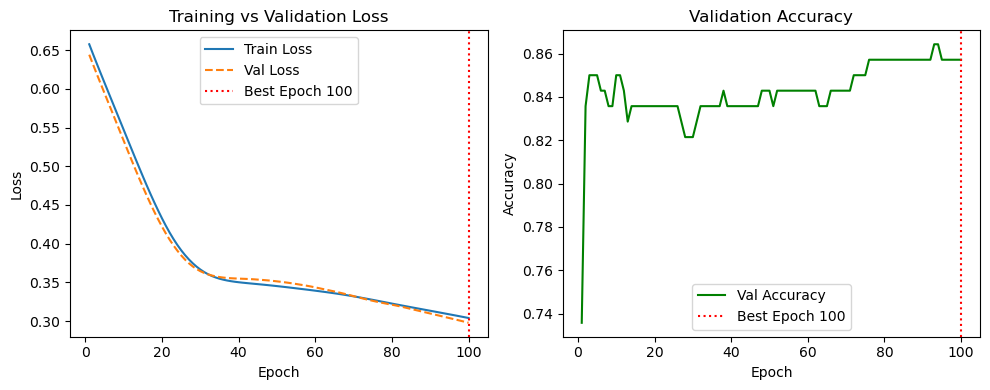

In [21]:
import matplotlib.pyplot as plt

epochs = history["epoch"]
train_loss = history["train_loss"]
val_loss = history["val_loss"]
val_acc = history["val_acc"]

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4))

# --- Loss Plot ---
ax1.plot(epochs, train_loss, label="Train Loss")
ax1.plot(epochs, val_loss, label="Val Loss", linestyle="--")
ax1.axvline(best_epoch, color="red", linestyle=":", label=f"Best Epoch {best_epoch}")
ax1.set_xlabel("Epoch")
ax1.set_ylabel("Loss")
ax1.set_title("Training vs Validation Loss")
ax1.legend()

# --- Accuracy Plot ---
ax2.plot(epochs, val_acc, color="green", label="Val Accuracy")
ax2.axvline(best_epoch, color="red", linestyle=":", label=f"Best Epoch {best_epoch}")
ax2.set_xlabel("Epoch")
ax2.set_ylabel("Accuracy")
ax2.set_title("Validation Accuracy")
ax2.legend()

plt.tight_layout()
plt.show()

### Challenge 2:
Introduce weight decay and dropout; compare validation accuracy vs. a plain model under mild label noise.

**Step 1 — Inject mild label noise**

We’ll flip ≈ 5 % of the training labels at random.

In [23]:
import numpy as np

def add_label_noise(y, noise_ratio=0.05, num_classes=2, seed=42):
    """Randomly flips a fraction of labels."""
    rng = np.random.default_rng(seed)
    y_noisy = y.clone()
    n = len(y)
    n_flip = int(noise_ratio * n)
    idx = rng.choice(n, n_flip, replace=False)
    for i in idx:
        # flip 0→1 or 1→0 for binary case
        y_noisy[i] = (y_noisy[i] + 1) % num_classes
    return y_noisy

y_tr_noisy = add_label_noise(y_tr, noise_ratio=0.05)
print(f"Flipped {int(0.05 * len(y_tr))} labels out of {len(y_tr)}")


Flipped 28 labels out of 560


**Step 2 — Define plain vs. regularized models**

We’ll use the same architecture, but the second one includes dropout and weight decay.**

In [24]:
class TinyMLP_Regularized(nn.Module):
    def __init__(self, in_features=2, hidden=8, num_classes=2, p_dropout=0.3):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(in_features, hidden),
            nn.ReLU(),
            nn.Dropout(p=p_dropout),
            nn.Linear(hidden, num_classes)
        )
    def forward(self, x):
        return self.net(x)


**Step 3 — Reusable training function**

In [25]:
def train_and_eval(model, X_tr, y_tr, X_val, y_val, weight_decay=0.0, n_epochs=80, lr=0.01):
    loss_fn = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
    best_val = float('inf'); best_state = None
    for epoch in range(n_epochs):
        model.train()
        optimizer.zero_grad()
        logits = model(X_tr)
        loss = loss_fn(logits, y_tr)
        loss.backward()
        optimizer.step()

        model.eval()
        with torch.no_grad():
            val_loss = loss_fn(model(X_val), y_val).item()
        if val_loss < best_val:
            best_val = val_loss
            best_state = model.state_dict().copy()
    model.load_state_dict(best_state)

    with torch.no_grad():
        val_logits = model(X_val)
        val_acc = accuracy(val_logits, y_val)
    return best_val, val_acc


**Step 4 — Run both experiments**

In [26]:
torch.manual_seed(42)

# Plain model (no regularization)
plain = TinyMLP(in_features=2, hidden=8, num_classes=2)
plain_loss, plain_acc = train_and_eval(plain, X_tr, y_tr_noisy, X_val, y_val)

# Regularized model (dropout + weight_decay)
reg = TinyMLP_Regularized(in_features=2, hidden=8, num_classes=2, p_dropout=0.3)
reg_loss, reg_acc = train_and_eval(reg, X_tr, y_tr_noisy, X_val, y_val, weight_decay=1e-3)

print(f"Plain Model → Val Loss: {plain_loss:.4f} | Val Acc: {plain_acc:.3f}")
print(f"Reg Model   → Val Loss: {reg_loss:.4f} | Val Acc: {reg_acc:.3f}")


Plain Model → Val Loss: 0.3352 | Val Acc: 0.857
Reg Model   → Val Loss: 0.3504 | Val Acc: 0.843


**Step 5 — Compare Training Dynamics: Plain vs Regularized**
**Step 5.1 — Modified training function with logging**

In [27]:
def train_with_history(model, X_tr, y_tr, X_val, y_val, weight_decay=0.0,
                       n_epochs=80, lr=0.01, label="Model"):
    loss_fn = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
    
    history = {"epoch": [], "val_loss": [], "val_acc": []}
    
    for epoch in range(1, n_epochs + 1):
        model.train()
        optimizer.zero_grad()
        logits = model(X_tr)
        loss = loss_fn(logits, y_tr)
        loss.backward()
        optimizer.step()

        model.eval()
        with torch.no_grad():
            val_logits = model(X_val)
            val_loss = loss_fn(val_logits, y_val).item()
            val_acc = accuracy(val_logits, y_val)

        history["epoch"].append(epoch)
        history["val_loss"].append(val_loss)
        history["val_acc"].append(val_acc)

    print(f"{label} → Final Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.3f}")
    return history


**Step 5.2 — Train both models with history tracking**

In [30]:
torch.manual_seed(42)

plain_hist = train_with_history(
    TinyMLP(in_features=2, hidden=8, num_classes=2),
    X_tr, y_tr_noisy, X_val, y_val,
    label="Plain Model"
)

reg_hist = train_with_history(
    TinyMLP_Regularized(in_features=2, hidden=8, num_classes=2, p_dropout=0.3),
    X_tr, y_tr_noisy, X_val, y_val,
    weight_decay=1e-3,
    label="Regularized Model"
)


Plain Model → Final Val Loss: 0.3352 | Val Acc: 0.857
Regularized Model → Final Val Loss: 0.3504 | Val Acc: 0.843


**Step 5.3 — Plot both validation curves**

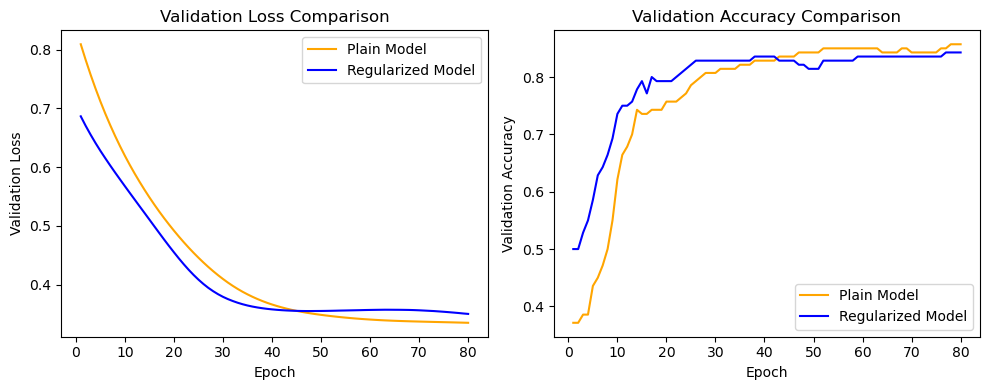

In [31]:
import matplotlib.pyplot as plt

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4))

# --- Loss ---
ax1.plot(plain_hist["epoch"], plain_hist["val_loss"], label="Plain Model", color="orange")
ax1.plot(reg_hist["epoch"], reg_hist["val_loss"], label="Regularized Model", color="blue")
ax1.set_xlabel("Epoch")
ax1.set_ylabel("Validation Loss")
ax1.set_title("Validation Loss Comparison")
ax1.legend()

# --- Accuracy ---
ax2.plot(plain_hist["epoch"], plain_hist["val_acc"], label="Plain Model", color="orange")
ax2.plot(reg_hist["epoch"], reg_hist["val_acc"], label="Regularized Model", color="blue")
ax2.set_xlabel("Epoch")
ax2.set_ylabel("Validation Accuracy")
ax2.set_title("Validation Accuracy Comparison")
ax2.legend()

plt.tight_layout()
plt.show()


### Challenge 3 — Device-Aware Code
**Step 1 — Define the device**

In [32]:
import torch

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")


Using device: cpu


**Step 2 — Move model and tensors to the device**

In [33]:
# Model
model = TinyMLP(in_features=2, hidden=8, num_classes=2).to(device)

# Data
X_tr = X_tr.to(device)
y_tr = y_tr.to(device)
X_val = X_val.to(device)
y_val = y_val.to(device)
X_test = X_test.to(device)
y_test = y_test.to(device)

**Step 3 — Training loop update**

In [34]:
for epoch in range(1, n_epochs + 1):
    model.train()
    optimizer.zero_grad()
    logits = model(X_tr)
    loss = loss_fn(logits, y_tr)
    loss.backward()
    optimizer.step()

    model.eval()
    with torch.no_grad():
        val_logits = model(X_val)
        val_loss = loss_fn(val_logits, y_val).item()
        val_acc = accuracy(val_logits, y_val)


**Step 4 — Assert everything is aligned**

In [35]:
assert next(model.parameters()).device == X_tr.device, "Model and data not on same device!"
print("✅ All tensors and model parameters share the same device.")

✅ All tensors and model parameters share the same device.


### Challenge 4
Demonstrate safe checkpoint loading with `map_location='cpu'`; verify that CPU restores match GPU-trained metrics

**Step 1 — Simulate a “GPU-trained” checkpoint** 

In [36]:
# Pretend this model was trained on a GPU
model = TinyMLP(in_features=2, hidden=8, num_classes=2)
loss_fn = nn.CrossEntropyLoss()

# (Optional) quick re-train for a few epochs
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
for epoch in range(10):
    model.train()
    optimizer.zero_grad()
    logits = model(X_tr)
    loss = loss_fn(logits, y_tr)
    loss.backward()
    optimizer.step()

# Save checkpoint "as if from GPU"
torch.save({'model': model.state_dict()}, 'gpu_trained_checkpoint.pt')
print("Simulated GPU-trained checkpoint saved.")


Simulated GPU-trained checkpoint saved.


**Step 2 — Load checkpoint safely on CPU**

In [37]:
# Safe CPU loading
checkpoint = torch.load('gpu_trained_checkpoint.pt', map_location='cpu')

restored_model = TinyMLP(in_features=2, hidden=8, num_classes=2)
restored_model.load_state_dict(checkpoint['model'])
restored_model.eval()

print("Checkpoint safely loaded on CPU.")


Checkpoint safely loaded on CPU.


**Step 3 — Verify consistency of metrics**

In [38]:
with torch.no_grad():
    logits_orig = model(X_test)
    logits_restored = restored_model(X_test)

print("Identical logits:",
      torch.allclose(logits_orig, logits_restored, atol=1e-6))

test_acc = accuracy(logits_restored, y_test)
print(f"Test accuracy after restore: {test_acc:.3f}")


Identical logits: True
Test accuracy after restore: 0.810
